In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.optimize import curve_fit
import os
import time

In [2]:
# Автооглавление README

file = open("../README.md")

lines = file.readlines()

contents = "# Содержание\n\n"
counters = [0] * 4
level = 0

for line in lines:
    if not line.startswith("#") or line == "# Содержание\n":
        continue

    cur_level = 0
    while (cur_level + 1) < len(line) and line[cur_level + 1] == "#":
        cur_level += 1

    if cur_level >= len(counters):
        print("Error. More counters needed")

    if cur_level < level:
        for i in range(cur_level + 1, len(counters)):
            counters[i] = 0

    level = cur_level

    header = line[cur_level + 2:-1]

    link = "#" + header.lower().replace(" ", "-").replace("(", "").replace(")", "").replace(".", "").replace("`", "").replace(":","").replace("+", "")

    contents += "    " * cur_level + str(counters[cur_level] + 1) + ". [" + header + "](" + link + ")\n"
    counters[cur_level] += 1

print(contents)

# Содержание

1. [Хеш таблица](#хеш-таблица)
2. [Оптимизация хеш таблицы](#оптимизация-хеш-таблицы)
    1. [Сравнение хеш-функций](#сравнение-хеш-функций)
        1. [Замечание о циклических сдвигах](#замечание-о-циклических-сдвигах)
    2. [Оптимизации](#оптимизации)
    3. [Варианты программы:](#варианты-программы)
        1. [1. `debug` - дебаг версия без оптимизаций](#1-debug---дебаг-версия-без-оптимизаций)
        2. [2. `base` - базовая версия без оптимизаций](#2-base---базовая-версия-без-оптимизаций)
        3. [3. `crc` - замена хеша на `CRC32` и ассемблерная оптимизация](#3-crc---замена-хеша-на-crc32-и-ассемблерная-оптимизация)
        4. [4. `crc + cmp` - предыдущее + оптимизация сравнения строк](#4-crc--cmp---предыдущее--оптимизация-сравнения-строк)
    4. [Итоговые измерения](#итоговые-измерения)
    5. [Сравнение результатов `callgrind` и `perf`](#сравнение-результатов-callgrind-и-perf)
    6. [Вывод](#вывод)
3. [Источники и инструменты](#источники-и-инструменты)
4. [Благо

In [41]:
def large_int_to_str(n):
    n = str(int(n))

    res = ""

    for i in range(len(n)):
        if i != 0 and i % 3 == 0:
            res += "&nbsp;"[::-1]
        res += n[-1 - i]

    return res[::-1]

In [42]:
callgrind_results = [[[3353201, 3353202, 3353202], [3174739, 3174739, 3174739]],
                     [[1303464, 1303464, 1303464], [509791 + 499684 + 140526, 509791 + 499684 + 140526, 509791 + 499684 + 140526]],
                     [[864300, 864300, 864300], [509995 + 230863, 509995 + 230863, 509995 + 230863]],
                     [[626931, 626931, 626931], [272627 + 230863, 272627 + 230863, 272627 + 230863]]]

perf_results = [[[4475, 4574, 4498], [3620, 3709, 3630]],
                [[2029, 2001, 2123], [1913, 1870, 1907]],
                [[1523, 1520, 1534], [1390, 1405, 1419]],
                [[1390, 1381, 1386], [1267, 1248, 1262]]]

names = ["debug", "base", "crc", "crc + cmp"]

def make_table(results, unit):
    global names

    print("""
<table>
    <thead>
        <tr>
            <th rowspan=2>Оптимизация</th>
            <th colspan=3 style="text-align: center">Вся программа</th>
            <th colspan=3 style="text-align: center">Функция поиска</th>
        </tr>
        <tr>
            <th style="text-align: center">""" + unit + """</th>
            <th style="text-align: center">% от base</th>
            <th style="text-align: center">% от предыдущего</th>
            <th style="text-align: center">""" + unit + """</th>
            <th style="text-align: center">% от base</th>
            <th style="text-align: center">% от предыдущего</th>
        </tr>
    </thead>
    <tbody>""")

    for i in range(len(results)):
        print(" " * 8 + "<tr>")
        print(" " * 12 + "<td>" + names[i] + "</td>")

        for j in range(2):
            print(" " * 12 + "<td style=\"text-align: center\">" + large_int_to_str(np.average(results[i][j]).round()) + " +- " + large_int_to_str(np.std(results[i][j]).round()) + "</td>")

            from_base = str(round(np.average(results[i][j]) / np.average(results[1][j]) * 100)) + "%"

            if i != 0:
                from_prev = str(round(np.average(results[i][j]) / np.average(results[i - 1][j]) * 100)) + "%"
            else:
                from_prev = ""

            print(" " * 12 + "<td style=\"text-align: center\">" + from_base + "</td>")
            print(" " * 12 + "<td style=\"text-align: center\">" + from_prev + "</td>")
        print(" " * 8 + "</tr>")

    print("""    </tbody>
</table>""")


In [43]:
make_table(callgrind_results, "Ir * 10^3")


<table>
    <thead>
        <tr>
            <th rowspan=2>Оптимизация</th>
            <th colspan=3 style="text-align: center">Вся программа</th>
            <th colspan=3 style="text-align: center">Функция поиска</th>
        </tr>
        <tr>
            <th style="text-align: center">Ir * 10^3</th>
            <th style="text-align: center">% от base</th>
            <th style="text-align: center">% от предыдущего</th>
            <th style="text-align: center">Ir * 10^3</th>
            <th style="text-align: center">% от base</th>
            <th style="text-align: center">% от предыдущего</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>debug</td>
            <td style="text-align: center">3&nbsp;353&nbsp;202 +- 0</td>
            <td style="text-align: center">257%</td>
            <td style="text-align: center"></td>
            <td style="text-align: center">3&nbsp;174&nbsp;739 +- 0</td>
            <td style="text-align: center">276%</td>
         

In [44]:
make_table(perf_results, "Cycles * 10^6")


<table>
    <thead>
        <tr>
            <th rowspan=2>Оптимизация</th>
            <th colspan=3 style="text-align: center">Вся программа</th>
            <th colspan=3 style="text-align: center">Функция поиска</th>
        </tr>
        <tr>
            <th style="text-align: center">Cycles * 10^6</th>
            <th style="text-align: center">% от base</th>
            <th style="text-align: center">% от предыдущего</th>
            <th style="text-align: center">Cycles * 10^6</th>
            <th style="text-align: center">% от base</th>
            <th style="text-align: center">% от предыдущего</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>debug</td>
            <td style="text-align: center">4&nbsp;516 +- 42</td>
            <td style="text-align: center">220%</td>
            <td style="text-align: center"></td>
            <td style="text-align: center">3&nbsp;653 +- 40</td>
            <td style="text-align: center">193%</td>
            <td s

[[3353201000, 3353202000, 3353202000], [3174739000, 3174739000, 3174739000], [1303464000, 1303464000, 1303464000], [1150001000, 1150001000, 1150001000], [864300000, 864300000, 864300000], [740858000, 740858000, 740858000], [626931000, 626931000, 626931000], [503490000, 503490000, 503490000]]


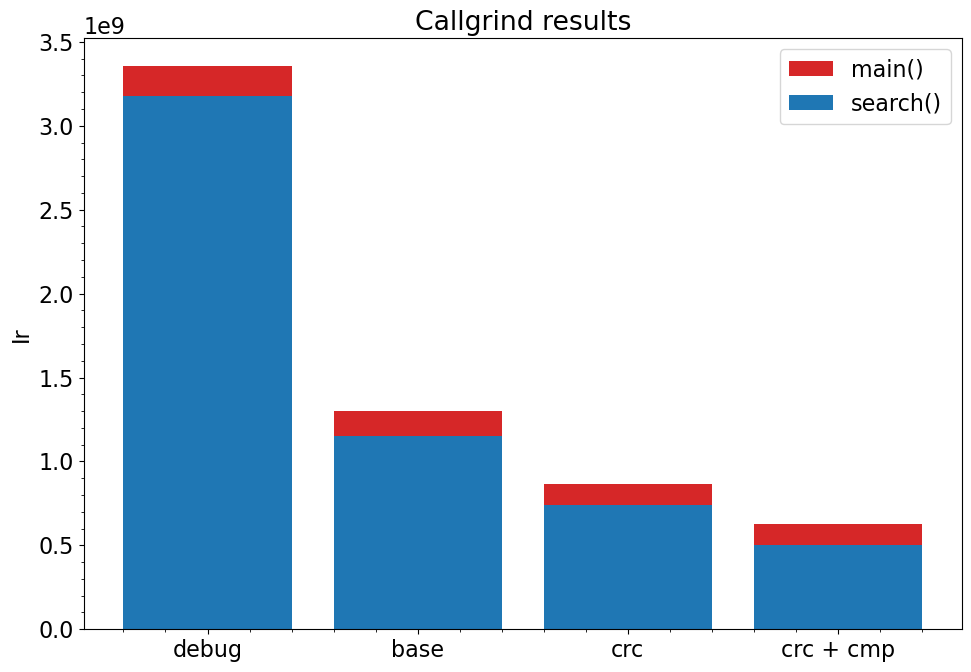

In [45]:
mpl.rcParams['font.size'] = 16
plt.figure(figsize = (10,7), facecolor = "white")

labels = []
for i in names:
    labels.append(" ")
    labels.append(i)
    labels.append(" ")
y = [y_ for y__ in callgrind_results for y_ in y__]
for i in range(len(y)):
    for j in range(len(y[i])):
        y[i][j] *= 1000

print(y)

bar_colors = ['tab:red', 'tab:blue']

bars = []
for i in range(len(y)):
    bars.append(plt.bar(names[i // 2], np.average(y[i]), color = bar_colors[i % 2], yerr = np.std(y[i]), error_kw=dict(lw=75), ecolor = "orange"))

plt.legend(["main()", "search()"], loc='upper right')

plt.ylabel("Ir")
plt.title("Callgrind results")

plt.minorticks_on()
plt.tight_layout()

plt.savefig("../img/callgrind_bar_chart.png")
plt.show()

[[4475000000, 4574000000, 4498000000], [3620000000, 3709000000, 3630000000], [2029000000, 2001000000, 2123000000], [1913000000, 1870000000, 1907000000], [1523000000, 1520000000, 1534000000], [1390000000, 1405000000, 1419000000], [1390000000, 1381000000, 1386000000], [1267000000, 1248000000, 1262000000]]


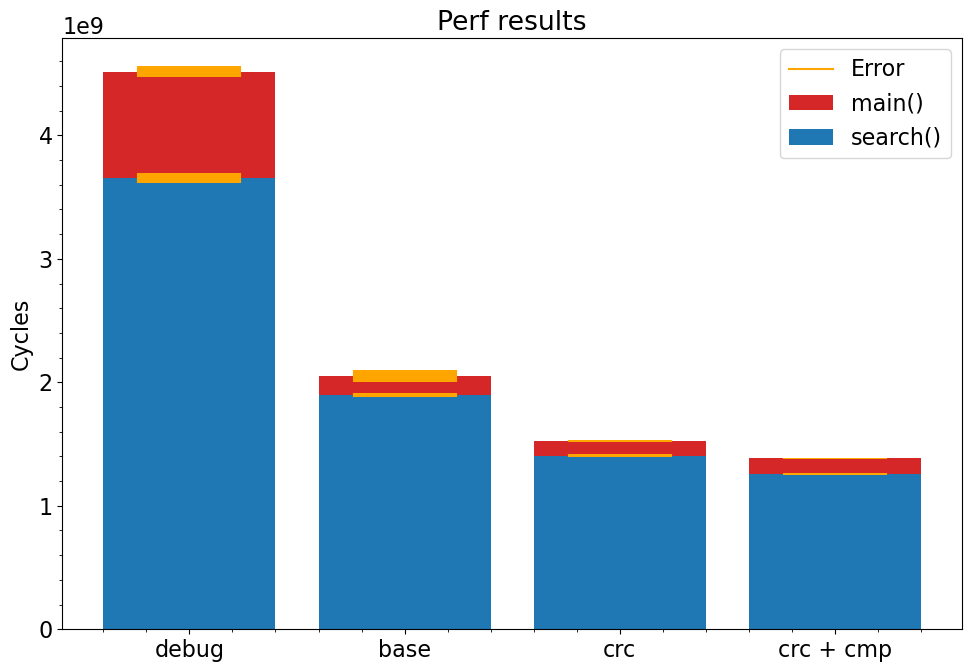

In [63]:
mpl.rcParams['font.size'] = 16
plt.figure(figsize = (10,7), facecolor = "white")

labels = []
for i in names:
    labels.append(" ")
    labels.append(i)
    labels.append(" ")
y = [y_.copy() for y__ in perf_results for y_ in y__]
for i in range(len(y)):
    for j in range(len(y[i])):
        y[i][j] *= 1000_000

print(y)

bar_colors = ['tab:red', 'tab:blue']

bars = []
for i in range(len(y)):
    bars.append(plt.bar(names[i // 2], np.average(y[i]), color = bar_colors[i % 2], yerr = np.std(y[i]), error_kw=dict(lw=75), ecolor = "orange"))

plt.plot(0, 0, label = "Error", color = "orange")

plt.legend(["Error", "main()", "search()"], loc='upper right')

plt.ylabel("Cycles")
plt.title("Perf results")

plt.minorticks_on()
plt.tight_layout()

plt.savefig("../img/perf_bar_chart.png")
plt.show()